Trains a grammar encoder to predict meta-scene-tree production params (grammars) on the 2D box grammar.

In [3]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks_complex.grammar import *

Unconditional grammar outputs look like this:

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


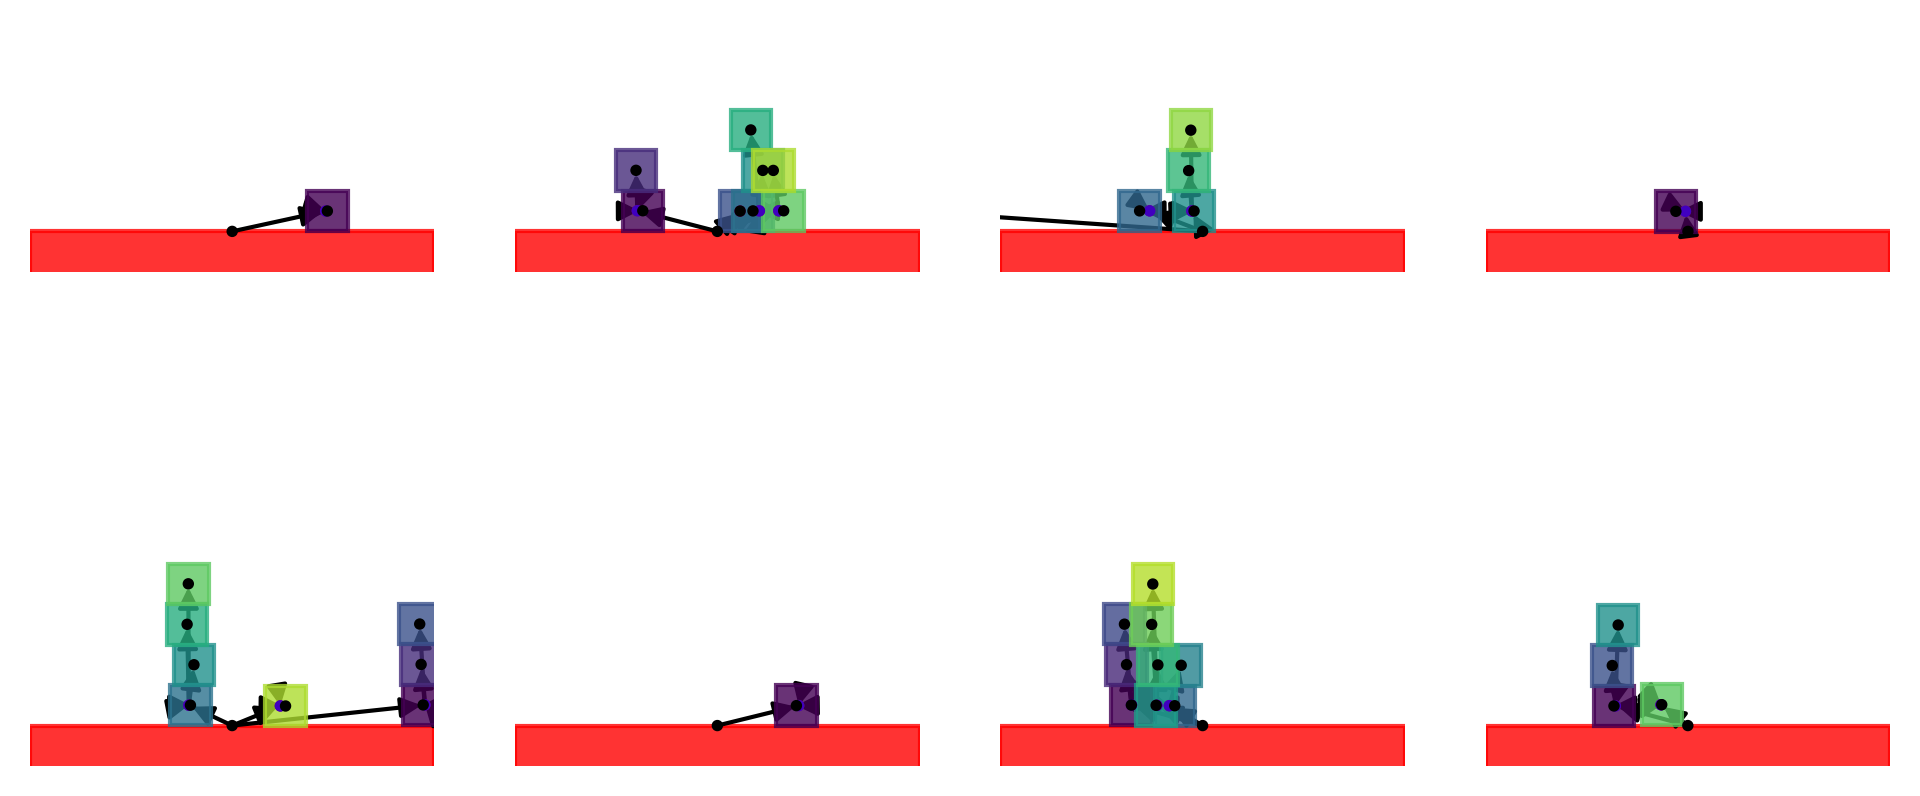

In [4]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = grammar()
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

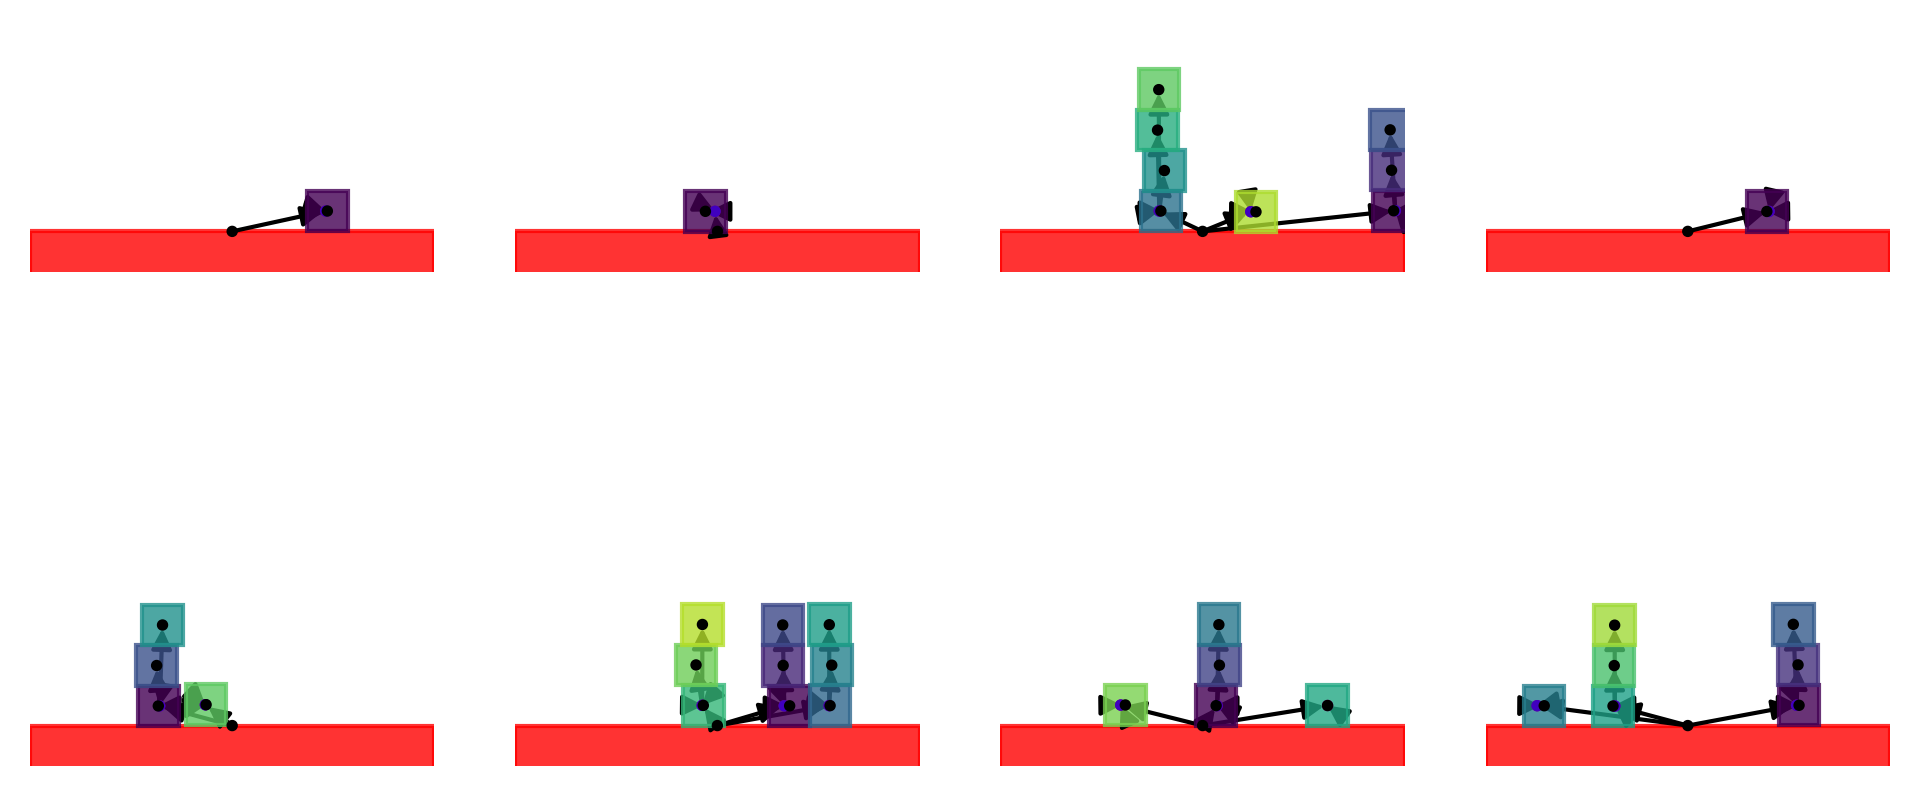

In [5]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [6]:
trace = pyro.poutine.trace(grammar.forward).get_trace()
print(trace.nodes.keys())

odict_keys(['_INPUT', 'Ground_26_sample_derived/xy', 'Ground_26_choose_children/sample_children_inclusion', 'Group_66_sample_derived/xy', 'Group_66_choose_children/sample_children_inclusion', 'Stack_59_sample_derived/xy', 'Stack_59_choose_children/sample_children_inclusion', 'Box_130_sample_derived/xy', 'Box_131_sample_derived/xy', '_RETURN'])


The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(339.81345000000005, 977.61655, -37.33605, 600.34605)

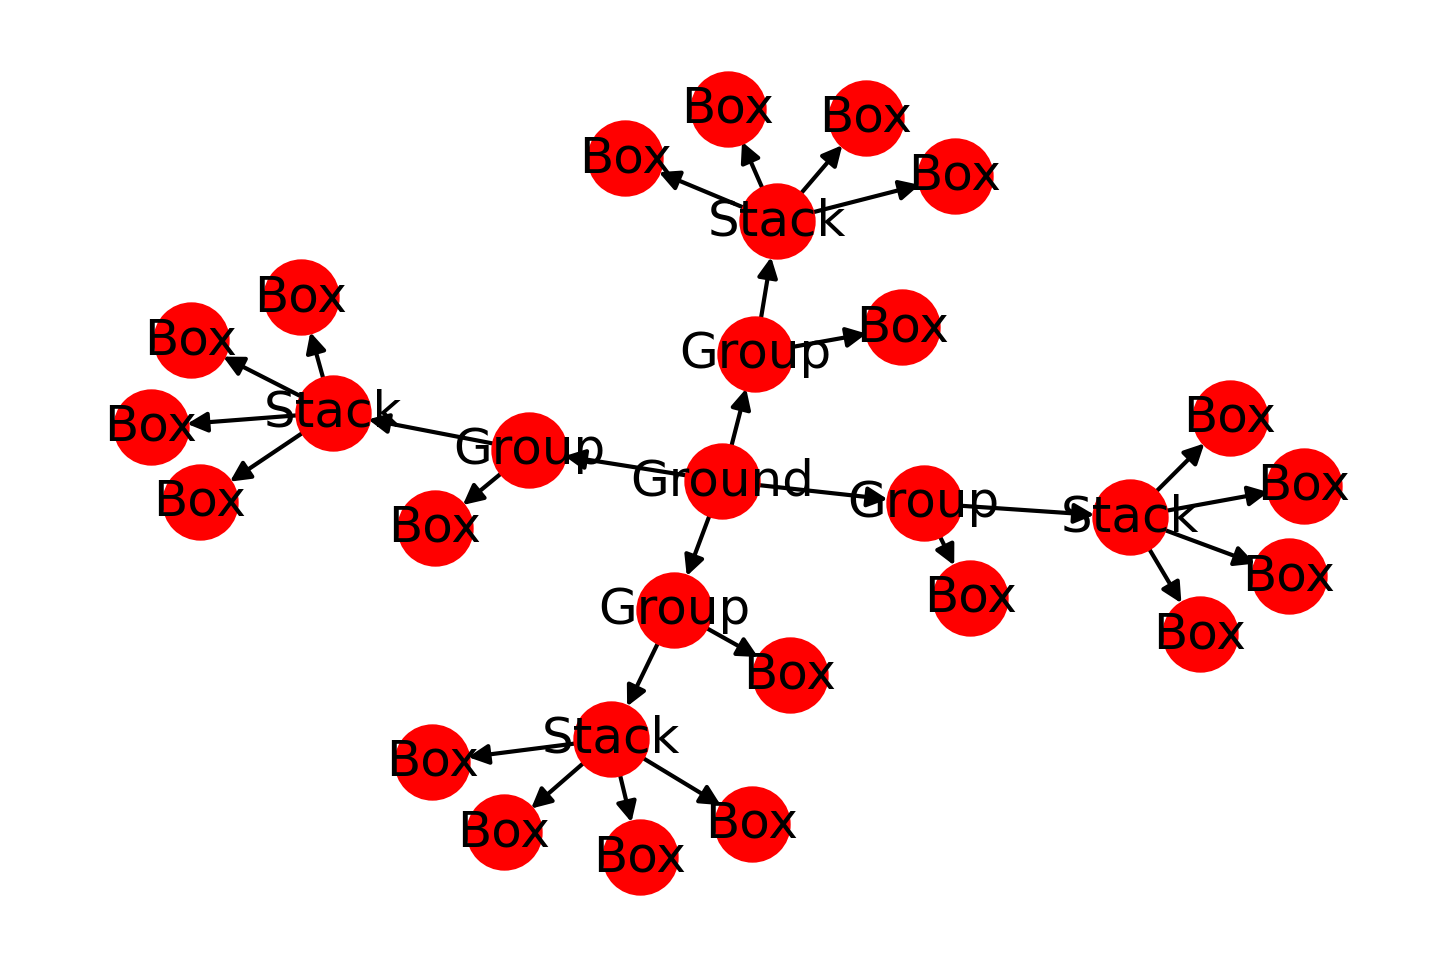

In [7]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneGrammar.make_super_scene_tree(Ground)
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

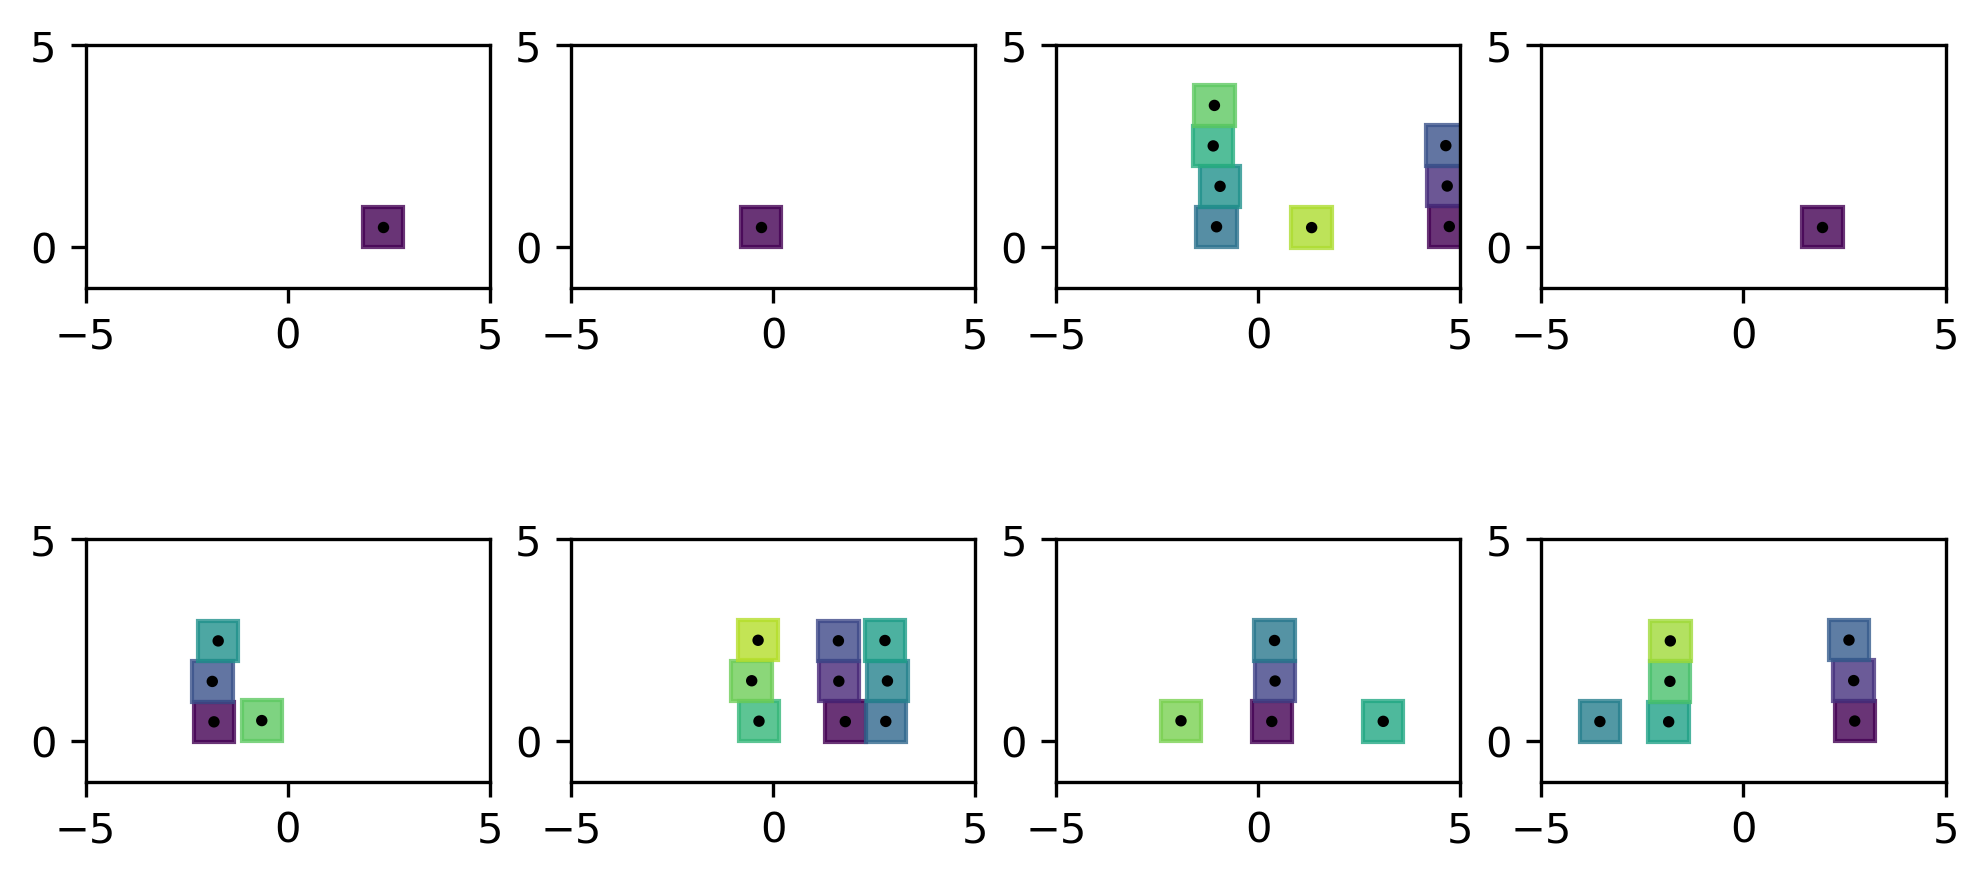

In [8]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## Neural grammar proposal generator on various grammars

Train an encoder to take a set of observed nodes and produce distributions over grammar parameters that are more likely to have generated those specific nodes.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is a fixed-size embedding and hidden state is the parameters of the distribution over parameters . Embeddings are generated by per-observed-node-type networks to transform variable-size node parameters into a fixed size parameter vector. 

#### Decoder and observation likelihood

A different scene grammar is a decoder: this could be the original grammar, or a different richer grammar that can generate everything the original grammar can. Given the inference grammar's parameters $z$, it induces a distribution over trees.

To train the whole system:
- Directly supervised: Given a full tree from the original grammar, the terminal nodes are encoded, and the inference grammar parameters is encouraged to be close to one that would generate the ground-truth full tree.
- Unsupervised: An observed node set is encoded. Grammars are sampled and trees forward-generated from them; each is scored against the observed node set using a supplied likelihood function. The embedding and encoder params are optimized with REINFORCE. I think that if the likelihood function ends up being an unbiased estimate of p(observed | grammar params) (perhaps by sampling trees and then computing p(observed | tree)), then this is exactly a VAE.

In [9]:
# Test out the observation likelihood.
observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

tensor([0.], grad_fn=<DivBackward0>)


In [10]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(400)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [11]:
# Try it out with an overparam'd form of the original grammar
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = FullyParameterizedGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = SceneGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GRU")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 1:
    # Load encoder from saved run.
    #weight_path = "saved_models/20210609/encoder_supervised_gru_43.1707.torch"
    weight_path = "saved_models/checkpoints/1500_24.505.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

Text(0.5, 0.98, 'Draws from encoder/decoder before any training, on TEST')

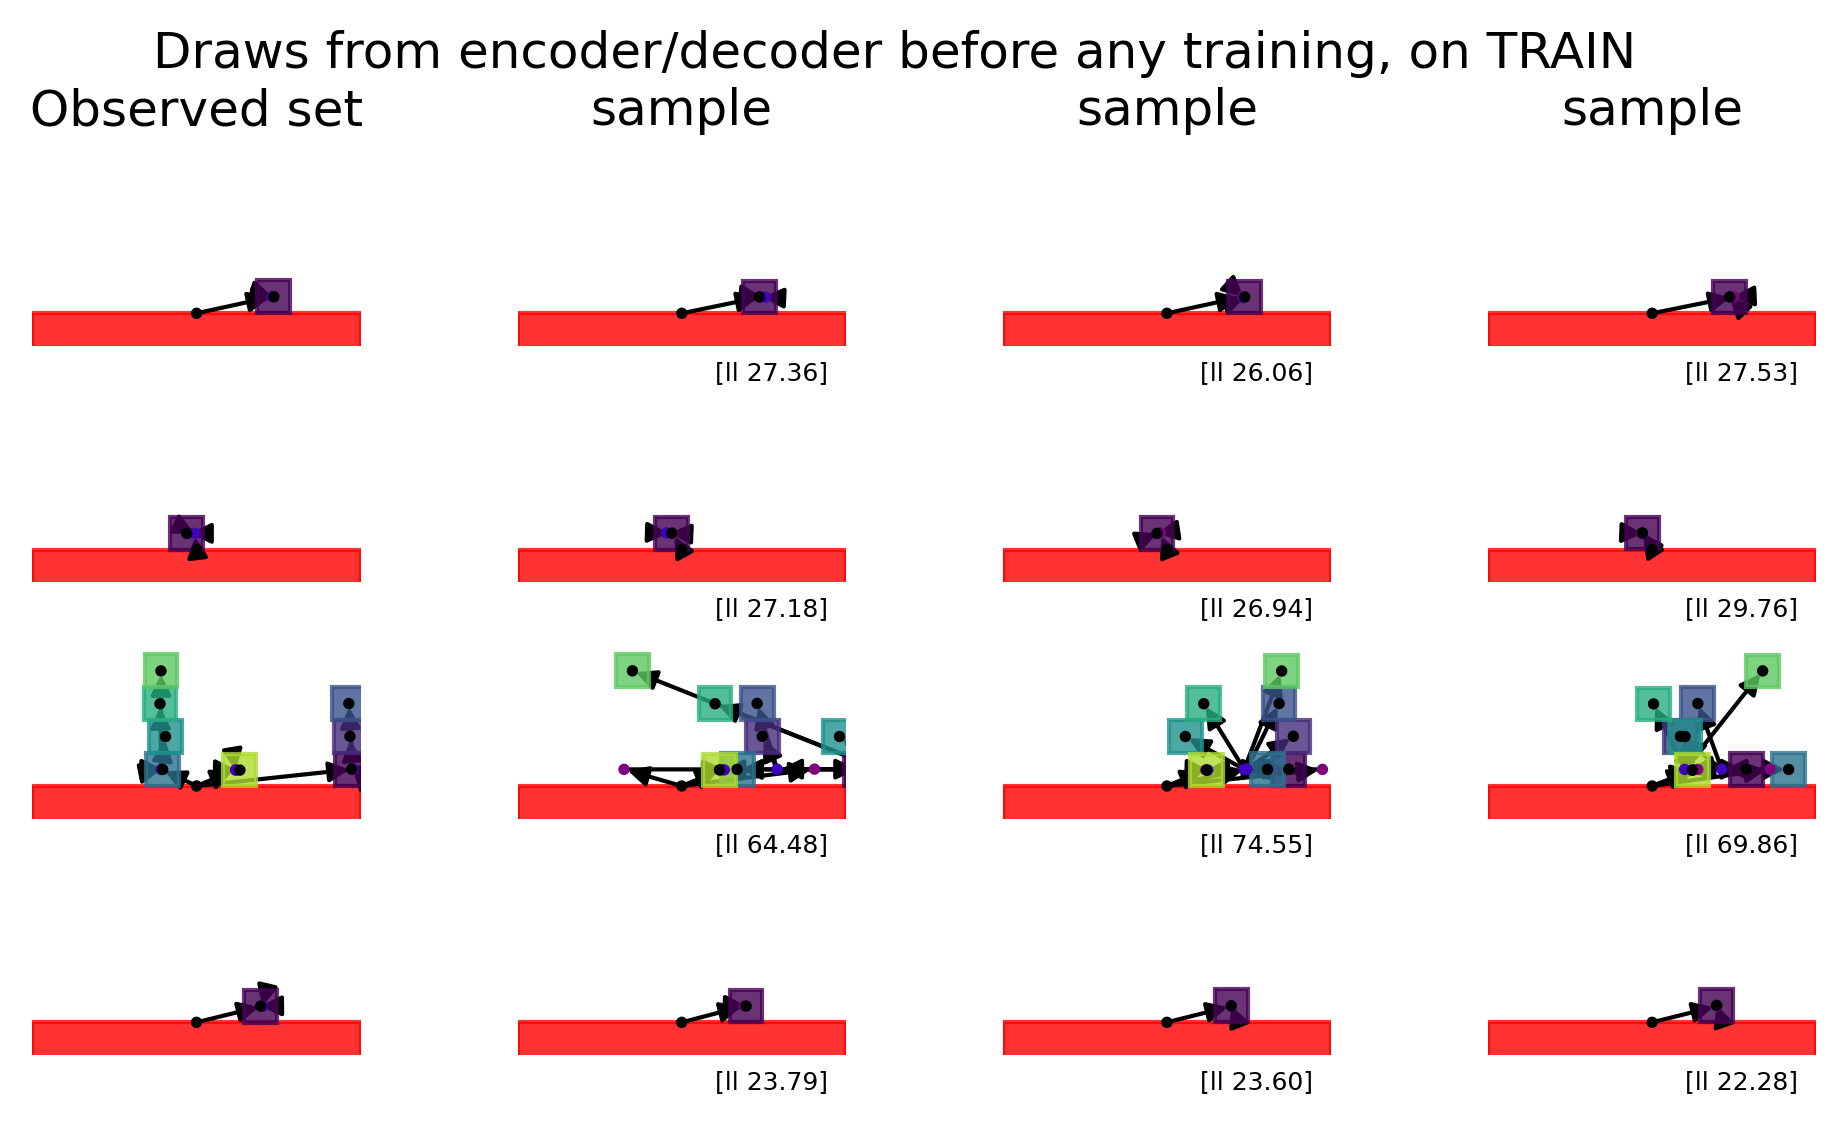

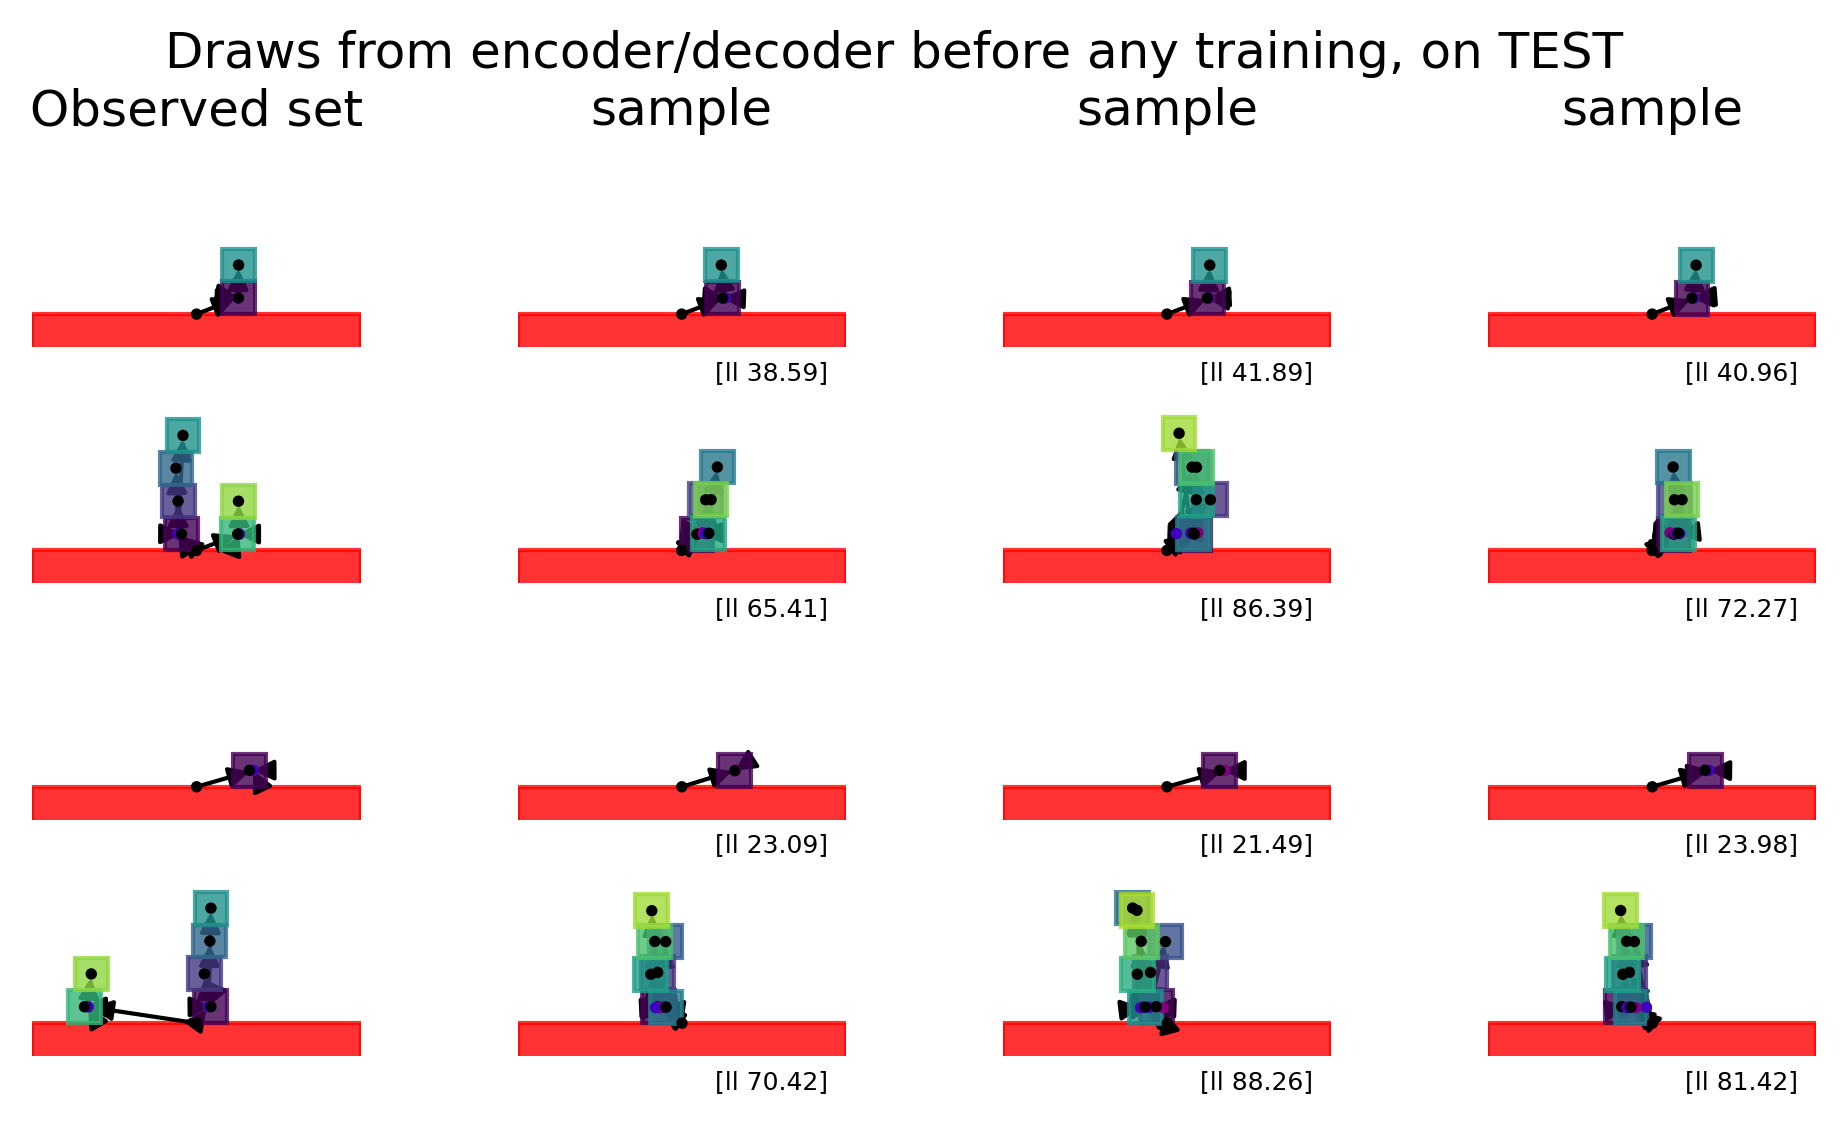

In [26]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(42)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder before any training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder before any training, on TEST")

0: 118.156548
100: -49.333401
200: -78.794350
300: -74.003868
400: -115.876129


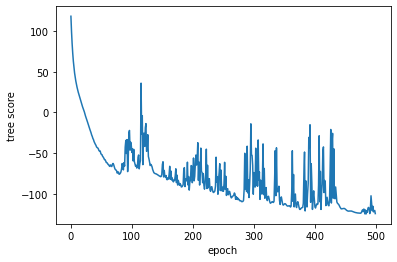

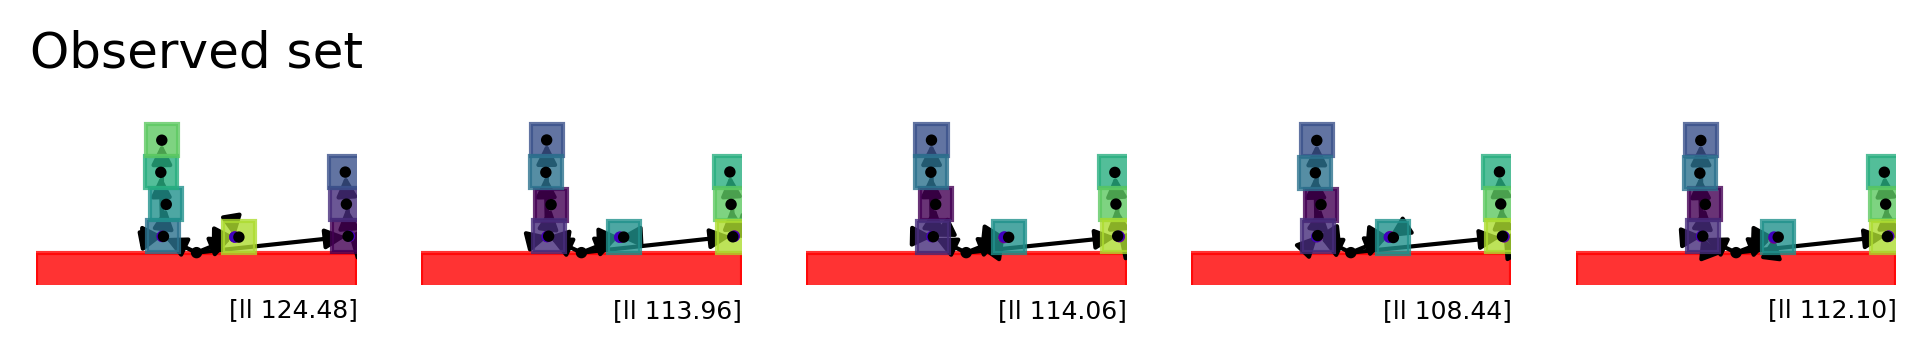

In [23]:
# Sanity-check grad descent: given a ground truth tree, can we
# recover the params of the auxiliary model that recover it?
full_tree = full_trees_for_training[2]
Nx = encoder.n_parameters
x = torch.normal(mean=torch.zeros(Nx), std=torch.ones(Nx)*0.1)
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=50, factor=0.5)
scores = []
for epoch in range(500):
    optimizer.zero_grad()
    score = -encoder.score_tree_with_grammar_vector(full_tree, x, detach=True)
    scores.append(score.detach().item())
    if epoch % 100 == 0:
        print("%d: %f" % (epoch, score))
    score.backward()
    optimizer.step()
    scheduler.step(score)
plt.plot(scores)
plt.xlabel("epoch")
plt.ylabel("tree score")
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 5
plt.subplot(1, N_width, 1)
draw_boxes(full_tree, fig=plt.gcf(), ax=plt.gca(), block=False)
plt.text(x=1., y=-2., s="[ll %0.2f]" % -score, fontsize=6)
plt.title("Observed set")
for k in range(N_width - 1):
    ax = plt.subplot(1, N_width, k + 2)
    plt.title("Sample %d" % k)
    sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
    draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
    plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

In [24]:
# Sanity check a simpler auxiliary task: can the encoder spit out x s.t. the first element of x
# is the number of objects?
# Training
N_EPOCHS = 500
N_ITERS_PER_EPOCH = 10
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=50, factor=0.5)

total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        total_objective += torch.mean(torch.square(x[0] - len(observed_nodes)))
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    if (epoch % 10 == 0):
        print("%d:Mean objective %.2f, lr %f"
              % (epoch, mean_objective, optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 10
plt.subplot(1, N_width, 1)
for k in range(N_width):
    ax = plt.subplot(1, N_width, k + 1)
    plt.title("Sample %d" % k)
    observed_nodes = observed_nodes_for_testing[k]
    x = encoder(observed_nodes)
    draw_boxes(full_trees_for_testing[k], fig=fig, ax=ax, block=False)
    plt.title("%0.1f" % x[0].item(), fontsize=6)

0:Mean objective 174.34, lr 0.001000
10:Mean objective 29.42, lr 0.001000
20:Mean objective 3.82, lr 0.001000
30:Mean objective 2.18, lr 0.001000
40:Mean objective 0.20, lr 0.001000
50:Mean objective 0.36, lr 0.001000
60:Mean objective 0.02, lr 0.000500
70:Mean objective 0.10, lr 0.000500
80:Mean objective 0.66, lr 0.000500
90:Mean objective 0.09, lr 0.000500
100:Mean objective 0.05, lr 0.000500
110:Mean objective 0.04, lr 0.000250
120:Mean objective 0.23, lr 0.000250
130:Mean objective 0.05, lr 0.000250
140:Mean objective 0.07, lr 0.000250
150:Mean objective 0.05, lr 0.000250
160:Mean objective 0.02, lr 0.000125
170:Mean objective 0.02, lr 0.000125
180:Mean objective 0.08, lr 0.000125
190:Mean objective 0.28, lr 0.000125
200:Mean objective 0.01, lr 0.000125
210:Mean objective 0.02, lr 0.000063
220:Mean objective 0.01, lr 0.000063
230:Mean objective 0.03, lr 0.000063
240:Mean objective 0.01, lr 0.000063


KeyboardInterrupt: 

# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, encode its observed nodes to get an inference grammar parameter set x, and then score the ground truth tree under that parameter set; backprob through x to increase the log-prob of the ground truth tree.

In [ ]:
N_EPOCHS = 5000
N_ITERS_PER_EPOCH = 50
CHECKPOINT_SAVE_PERIOD=250
CLIP_VALUE = 1E3
torch.manual_seed(1234)

SETUP_TRAINING = False

def save_encoder_state(save_path):
    print("Saving to path ", save_path)
    try:
        dir_to_make = os.path.split(save_path)[0]
        if dir_to_make is not "":
            os.makedirs(dir_to_make)
    except FileExistsError:
        pass
    torch.save(encoder.state_dict(), save_path)
    print("Saved model to %s" % save_path)
    
checkpoint_save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime()),
    "checkpoints"
)

if SETUP_TRAINING:
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=250, factor=0.5)

    continuous_score_history = []
    discrete_score_history = []
    total_objective_history = []
    score_history = []
    all_gradients_history = {name: [] for name, _ in encoder.named_parameters()}
    epoch = 0

while epoch < N_EPOCHS:
    total_discrete_score = 0.
    total_continuous_score = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        
        full_tree = full_trees_for_training[iter_k]
        discrete_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=True,
            include_continuous=False
        )
        total_discrete_score += discrete_score
        continuous_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=False,
            include_continuous=True
        )
        total_continuous_score += continuous_score
    
    mean_discrete_score = total_discrete_score / N_ITERS_PER_EPOCH
    mean_continuous_score = total_continuous_score / N_ITERS_PER_EPOCH
    
    discrete_score_history.append(mean_discrete_score.detach())
    continuous_score_history.append(mean_continuous_score.detach())

    # Weight continuous factor to bring it to the same order of
    # magnitude as the discrete score.
    #avg_d = torch.tensor(discrete_score_history[-AVERAGE_WINDOW]).mean()
    #avg_c = torch.tensor(continuous_score_history[-AVERAGE_WINDOW]).mean()
    
    mean_objective = mean_discrete_score * 10. + mean_continuous_score
    total_objective_history.append(mean_objective.detach())
    score_history.append(mean_objective)
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f, discrete %.2f, continuous %.2f, lr %f"
              % (epoch, mean_objective, mean_discrete_score, mean_continuous_score,
                 optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (-mean_objective).backward()
        # log gradients
        for name, param in encoder.named_parameters():
            if param.grad is None:
                all_gradients_history[name].append(torch.zeros(param.shape))
            else:
                all_gradients_history[name].append(deepcopy(param.grad.data))

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
    if (epoch >= 0 and epoch % CHECKPOINT_SAVE_PERIOD == 0):
        save_encoder_state("saved_models/checkpoints/%d_%0.03f.torch" % (epoch, total_objective_history[-1]))

    epoch += 1

supervised_training_finish_time = time.time()

1000:Mean objective 19.63, discrete -0.24, continuous 22.04, lr 0.001000
Saving to path  saved_models/checkpoints/1000_19.626.torch
Saved model to saved_models/checkpoints/1000_19.626.torch
1001:Mean objective 16.54, discrete -0.30, continuous 19.52, lr 0.001000
1002:Mean objective 14.82, discrete -0.19, continuous 16.74, lr 0.001000
1003:Mean objective 14.99, discrete -0.25, continuous 17.46, lr 0.001000
1004:Mean objective 16.64, discrete -0.26, continuous 19.21, lr 0.001000
1005:Mean objective 16.88, discrete -0.20, continuous 18.85, lr 0.001000
1006:Mean objective 16.96, discrete -0.24, continuous 19.38, lr 0.001000
1007:Mean objective 15.88, discrete -0.23, continuous 18.19, lr 0.001000
1008:Mean objective 17.54, discrete -0.24, continuous 19.92, lr 0.001000
1009:Mean objective 17.94, discrete -0.25, continuous 20.47, lr 0.001000
1010:Mean objective 16.11, discrete -0.30, continuous 19.09, lr 0.001000
1011:Mean objective 18.13, discrete -0.21, continuous 20.18, lr 0.001000
1012:Me

1111:Mean objective 17.28, discrete -0.18, continuous 19.09, lr 0.001000
1112:Mean objective 15.64, discrete -0.21, continuous 17.74, lr 0.001000
1113:Mean objective 17.02, discrete -0.23, continuous 19.29, lr 0.001000
1114:Mean objective 16.89, discrete -0.23, continuous 19.20, lr 0.001000
1115:Mean objective 18.11, discrete -0.20, continuous 20.07, lr 0.001000
1116:Mean objective 19.66, discrete -0.13, continuous 20.94, lr 0.001000
1117:Mean objective 17.37, discrete -0.23, continuous 19.67, lr 0.001000
1118:Mean objective 17.68, discrete -0.23, continuous 20.02, lr 0.001000
1119:Mean objective 20.12, discrete -0.18, continuous 21.90, lr 0.001000
1120:Mean objective 18.64, discrete -0.22, continuous 20.81, lr 0.001000
1121:Mean objective 15.59, discrete -0.29, continuous 18.47, lr 0.001000
1122:Mean objective 18.13, discrete -0.29, continuous 21.02, lr 0.001000
1123:Mean objective 18.87, discrete -0.18, continuous 20.67, lr 0.001000
1124:Mean objective 18.90, discrete -0.25, continuo

1224:Mean objective 18.51, discrete -0.32, continuous 21.68, lr 0.001000
1225:Mean objective 19.30, discrete -0.15, continuous 20.82, lr 0.001000
1226:Mean objective 19.43, discrete -0.27, continuous 22.13, lr 0.001000
1227:Mean objective 18.82, discrete -0.24, continuous 21.23, lr 0.001000
1228:Mean objective 20.73, discrete -0.21, continuous 22.80, lr 0.001000
1229:Mean objective 21.47, discrete -0.19, continuous 23.33, lr 0.001000
1230:Mean objective 18.92, discrete -0.19, continuous 20.84, lr 0.001000
1231:Mean objective 20.48, discrete -0.25, continuous 22.95, lr 0.001000
1232:Mean objective 19.83, discrete -0.21, continuous 21.97, lr 0.001000
1233:Mean objective 22.54, discrete -0.21, continuous 24.64, lr 0.001000
1234:Mean objective 21.32, discrete -0.15, continuous 22.80, lr 0.001000
1235:Mean objective 18.59, discrete -0.21, continuous 20.68, lr 0.001000
1236:Mean objective 15.70, discrete -0.24, continuous 18.13, lr 0.001000
1237:Mean objective 20.08, discrete -0.23, continuo

1335:Mean objective 16.38, discrete -0.26, continuous 18.94, lr 0.001000
1336:Mean objective 16.43, discrete -0.26, continuous 19.06, lr 0.001000
1337:Mean objective 17.11, discrete -0.16, continuous 18.69, lr 0.001000
1338:Mean objective 19.10, discrete -0.20, continuous 21.14, lr 0.001000
1339:Mean objective 19.99, discrete -0.13, continuous 21.25, lr 0.001000
1340:Mean objective 18.47, discrete -0.30, continuous 21.42, lr 0.001000
1341:Mean objective 16.38, discrete -0.33, continuous 19.66, lr 0.001000
1342:Mean objective 20.25, discrete -0.23, continuous 22.59, lr 0.001000
1343:Mean objective 17.80, discrete -0.28, continuous 20.56, lr 0.001000
1344:Mean objective 15.59, discrete -0.28, continuous 18.36, lr 0.001000
1345:Mean objective 17.29, discrete -0.16, continuous 18.90, lr 0.001000
1346:Mean objective 18.36, discrete -0.16, continuous 19.96, lr 0.001000
1347:Mean objective 15.09, discrete -0.20, continuous 17.04, lr 0.001000
1348:Mean objective 17.31, discrete -0.23, continuo

1448:Mean objective 17.22, discrete -0.32, continuous 20.38, lr 0.001000
1449:Mean objective 20.21, discrete -0.18, continuous 22.00, lr 0.001000
1450:Mean objective 17.45, discrete -0.31, continuous 20.54, lr 0.001000
1451:Mean objective 19.42, discrete -0.18, continuous 21.20, lr 0.001000
1452:Mean objective 20.12, discrete -0.23, continuous 22.45, lr 0.001000
1453:Mean objective 22.13, discrete -0.11, continuous 23.27, lr 0.001000
1454:Mean objective 19.37, discrete -0.20, continuous 21.37, lr 0.001000
1455:Mean objective 20.73, discrete -0.14, continuous 22.15, lr 0.001000
1456:Mean objective 21.27, discrete -0.11, continuous 22.40, lr 0.001000
1457:Mean objective 17.67, discrete -0.18, continuous 19.50, lr 0.001000
1458:Mean objective 17.80, discrete -0.26, continuous 20.40, lr 0.001000
1459:Mean objective 17.13, discrete -0.21, continuous 19.25, lr 0.001000
1460:Mean objective 19.23, discrete -0.19, continuous 21.08, lr 0.001000
1461:Mean objective 18.83, discrete -0.26, continuo

1559:Mean objective 26.55, discrete -0.16, continuous 28.15, lr 0.000500
1560:Mean objective 24.08, discrete -0.18, continuous 25.91, lr 0.000500
1561:Mean objective 22.58, discrete -0.22, continuous 24.78, lr 0.000500
1562:Mean objective 24.62, discrete -0.18, continuous 26.45, lr 0.000500
1563:Mean objective 25.89, discrete -0.21, continuous 28.02, lr 0.000500
1564:Mean objective 27.89, discrete -0.13, continuous 29.16, lr 0.000500
1565:Mean objective 25.71, discrete -0.21, continuous 27.82, lr 0.000500
1566:Mean objective 25.87, discrete -0.21, continuous 27.98, lr 0.000500
1567:Mean objective 27.93, discrete -0.17, continuous 29.65, lr 0.000500
1568:Mean objective 25.50, discrete -0.25, continuous 28.02, lr 0.000500
1569:Mean objective 24.35, discrete -0.20, continuous 26.40, lr 0.000500
1570:Mean objective 23.29, discrete -0.25, continuous 25.83, lr 0.000500
1571:Mean objective 30.23, discrete -0.14, continuous 31.63, lr 0.000500
1572:Mean objective 23.55, discrete -0.15, continuo

In [ ]:
# Draw gradient norm history per param
plt.figure(dpi=300).set_size_inches(10, 10)
n_params = len(all_gradients_history.keys())
for k, (name, history) in enumerate(all_gradients_history.items()):
    ax = plt.subplot(5, n_params // 5 + 1, k+1)
    history = torch.stack(history)
    history = np.linalg.norm(history.reshape(history.shape[0], -1).numpy(), axis=1) + 1E-3
    x = range(history.shape[0])
    ax.plot(x, history)
    plt.yscale("log")
    #ax.fill_between(x, (means-std), (means+std), color='b', alpha=.1)
    plt.title(name, fontsize=6)

In [2]:
def set_reasonable_bounds(hist, lb, ub):
    low = max(np.min(hist) - 1. , lb)
    high = min(np.max(hist) + 1., ub)
    plt.ylim(low, high)
plt.figure(dpi=300).set_size_inches(9, 3)
plt.subplot(1, 3, 1)
plt.title("Total (proxy)")
plt.plot(total_objective_history)
set_reasonable_bounds([x.detach() for x in total_objective_history], -40, 100.)
plt.grid(True)
plt.subplot(1, 3, 2)
plt.title("Discrete")
plt.plot(discrete_score_history)
set_reasonable_bounds(discrete_score_history, -2., 100.)
plt.grid(True)
plt.subplot(1, 3, 3)
plt.title("Continuous")
plt.plot(continuous_score_history)
plt.grid(True)
set_reasonable_bounds(continuous_score_history, -40., 100)

NameError: name 'plt' is not defined

Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  4
Entering example  5
Entering example  6
Entering example  7
Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  4
Entering example  5
Entering example  6
Entering example  7


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

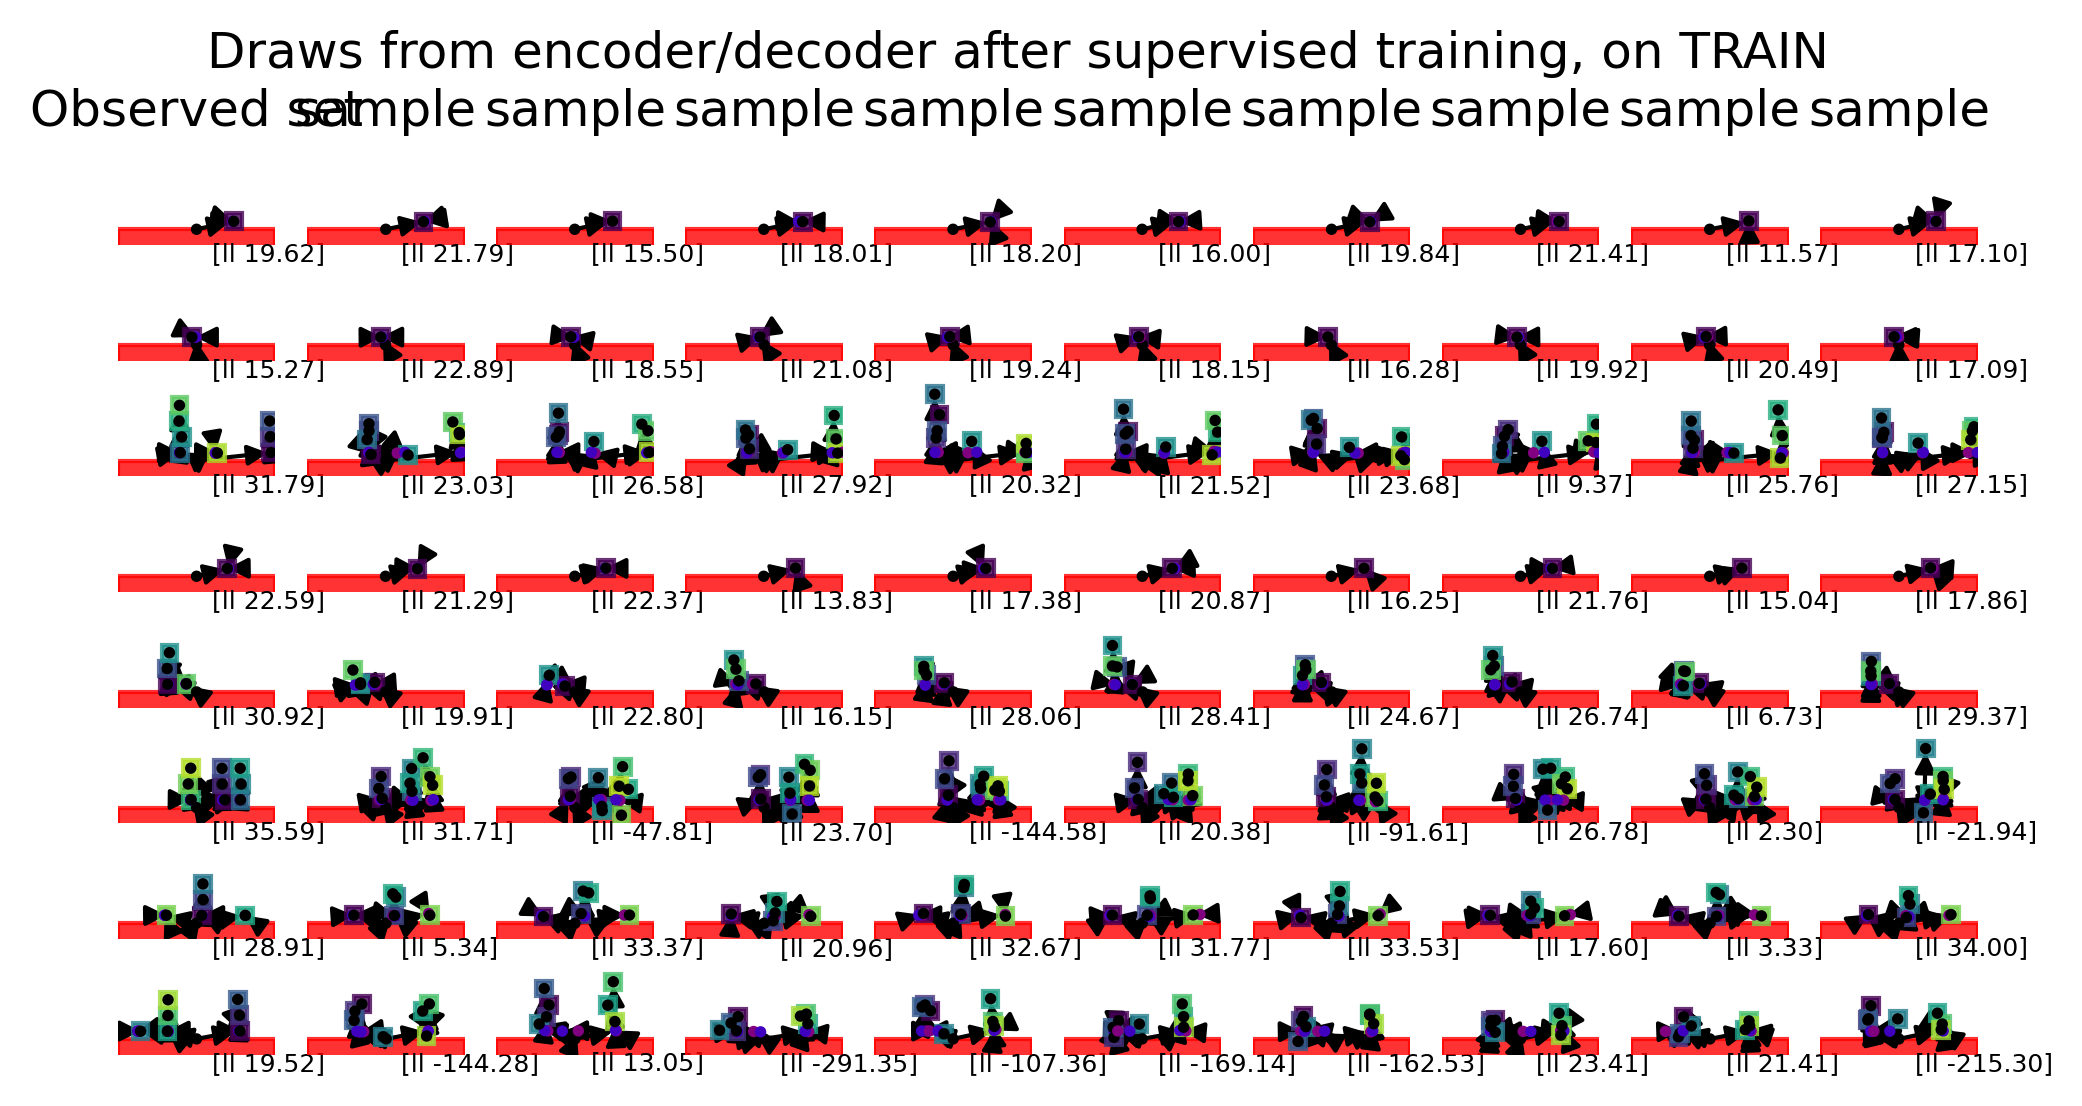

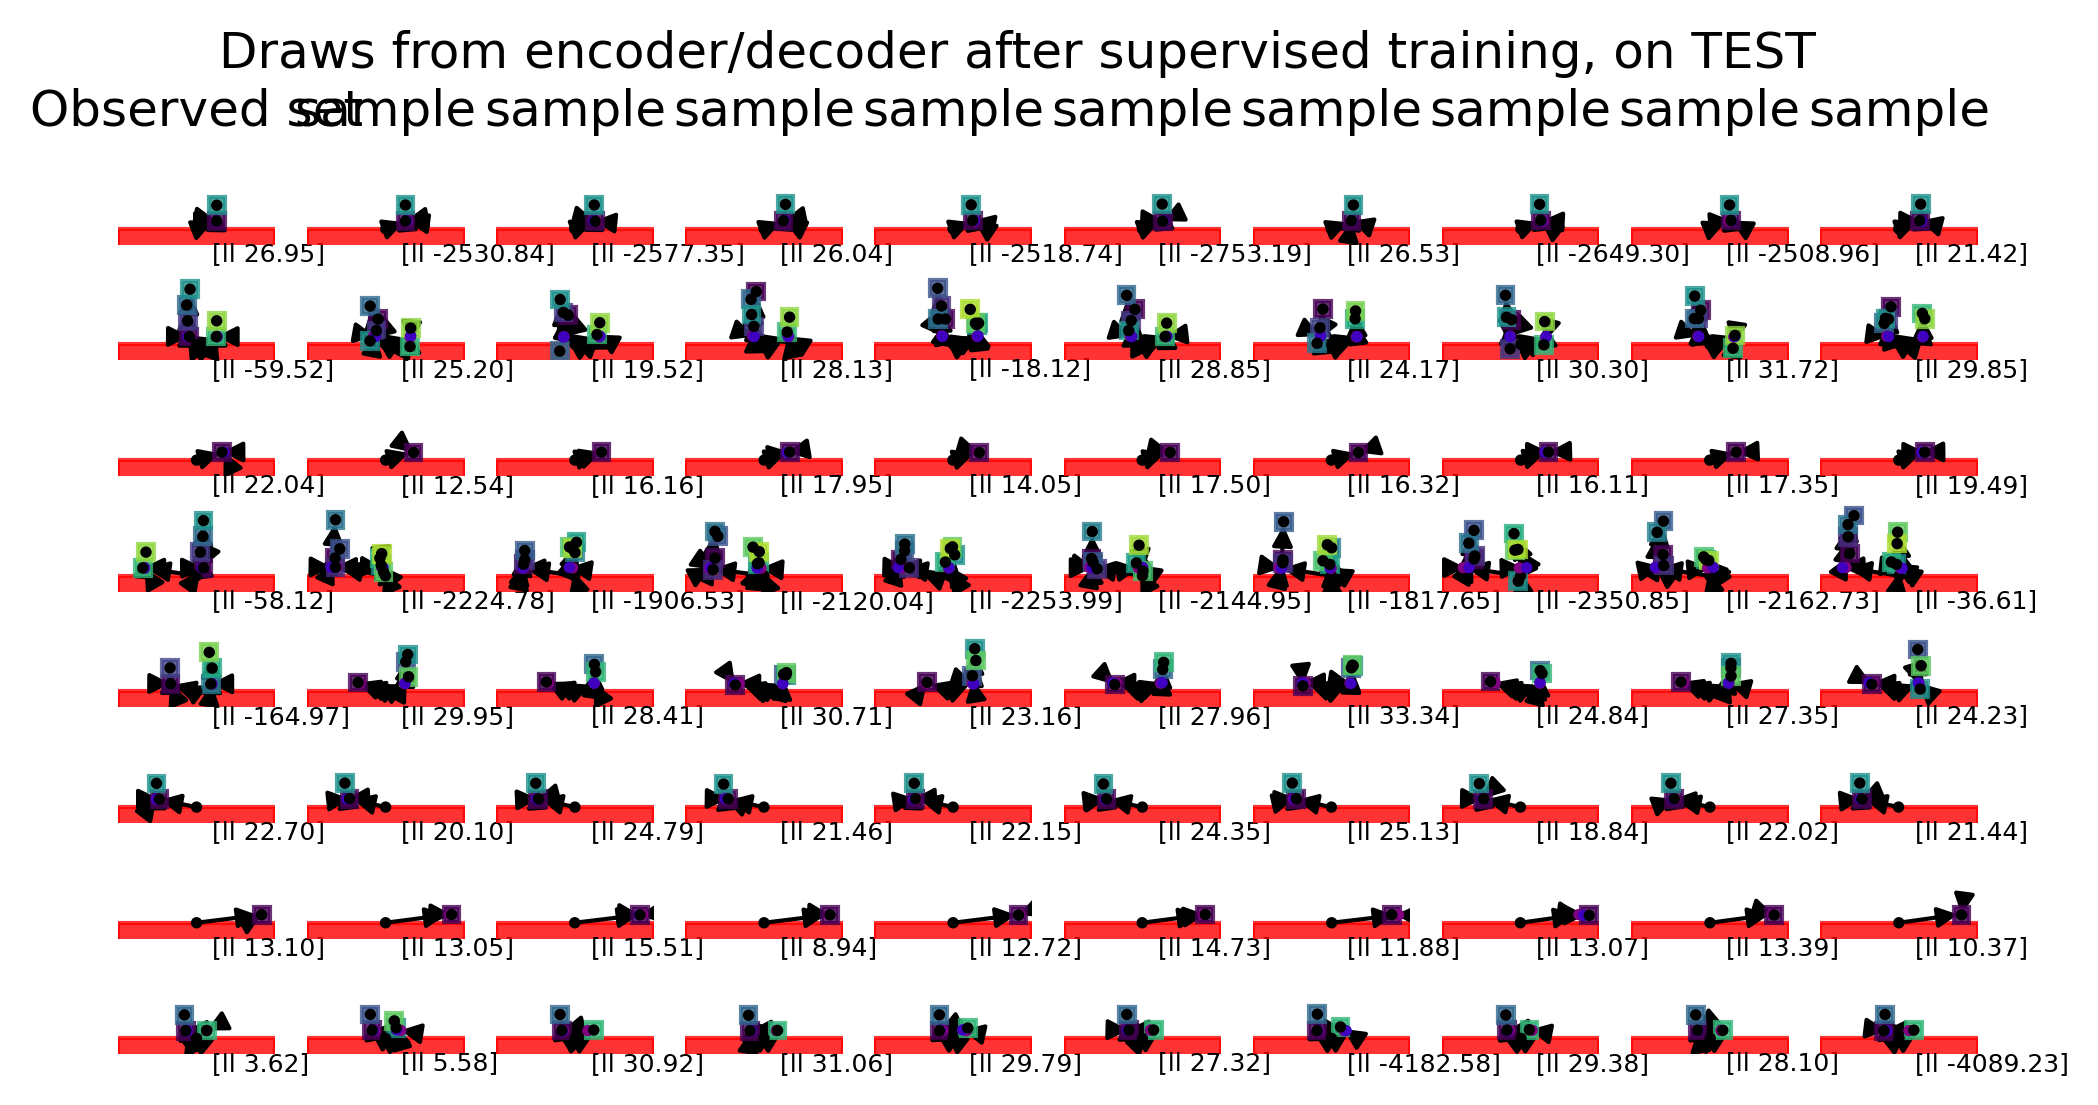

In [12]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 10
    N_height = 8
    torch.random.manual_seed(41)
    
    for i in range(N_height):
        print("Entering example ", i)
        plt.subplot(N_height, N_width, i*N_width + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        
        # Score the test tree under its encoded vector
        density = encoder.score_tree_with_grammar_vector(full_trees[i], x, include_continuous=True)
        plt.text(x=1., y=-2., s="[ll %0.2f]" % density, fontsize=6)
        
        for j in range(1, N_width):
            k = i*N_width + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, _, _ = encoder.sample_tree_from_grammar_vector(x)
            proposal_density = encoder.score_tree_with_grammar_vector(sampled_tree, x, include_continuous=True)
            #box_k = 0
            #for node in sampled_tree.nodes:
            #    if isinstance(node, Box):
            #        node.xy = torch.tensor([0., box_k])
            #        box_k += 1
            #    else:
            #        node.xy = torch.zeros(2)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

In [ ]:
# Save output
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime())
)
save_name = "encoder_supervised_gru_%0.04f.torch" % (
    total_objective_history[-1]
)
save_path = os.path.join(save_dir, save_name)
save_encoder_state(save_path)

In [ ]:
# Load output
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GRU")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 1:
    # Load encoder from saved run.
    weight_path = "saved_models/20210609/encoder_supervised_gru_43.1707.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior and original grammar prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \Big] + log p(\theta)$, for $f(t, t^*) = L(t, t^*) + p(t)$.

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ (f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [ ]:
# Training
from warmup_scheduler import GradualWarmupScheduler


N_EPOCHS = 450
N_ITERS_PER_EPOCH = 25
N_SAMPLES_PER_ENCODING = 4
MIN_LL_SATURATION = -10000

restart_training = True

torch.manual_seed(43)

SETUP_TRAINING = True

def save_encoder_state(save_path):
    print("Saving to path ", save_path)
    try:
        dir_to_make = os.path.split(save_path)[0]
        if dir_to_make is not "":
            os.makedirs(dir_to_make)
    except FileExistsError:
        pass
    torch.save(encoder.state_dict(), save_path)
    print("Saved model to %s" % save_path)
    
checkpoint_save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime()),
    "checkpoints"
)

if SETUP_TRAINING:
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=250, factor=0.5)
    mean_sampled_f_history = []
    mean_sampled_score_history = []
    total_objective_history = []
    epoch = 0
    
while epoch < N_EPOCHS:
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll * N_SAMPLES_PER_ENCODING
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = encoder.sample_tree_from_grammar_vector(x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            
            # Calculate observation matching score.
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1, detach_second=True) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1, detach_first=True)).sum()
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            
            # Calculate grammar prior score.
            grammar_ll = grammar.score(sampled_tree)
            
            # Total value under expectation for evaluation policy gradient.
            total_f = est_ll# + grammar_ll
            
            # Diagnostics
            total_sampled_score += est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * nonreparam_density_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)

    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f, lr %f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective, 
            optimizer.param_groups[0]['lr']))
    
    if torch.isfinite(mean_objective):
        # Parameter values get gradients calculated but not used;
        # need to retain them to keep pytorch from complaining.
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step(mean_objective)
    
    epoch += 1

unsupervised_training_finish_time = time.time()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

In [ ]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TEST")


In [ ]:
# Save weights
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime(supervised_training_finish_time))
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_unsupervised_%0.04f.torch" % (
    mean_sampled_f_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)